### Methods 1 - A model setup

The main idea of the study is to estimate an upper bound of alkalinity generation in the Wadden Sea.
The calculation of alkalinity is based on the concept of "explicitly conservative form of total alkalinity" ($\text{TA}_{\text{ec}}$) proposed by ([Wolf-Gladrow et al., 2007]):

$\text{TA}_{\text{ec}} = \lbrack\text{Na}^{+}\rbrack + 2\lbrack\text{Mg}^{2 +}\rbrack + 2\lbrack\text{Ca}^{2 +}\rbrack + \lbrack \text{K}^{+}\rbrack + 2\lbrack\text{Sr}^{2 +}\rbrack + \text{TNH}_{3} - \lbrack\text{Cl}^{-}\rbrack - \lbrack\text{Br}^{-}\rbrack - \lbrack\text{NO}_{3}^{-}\rbrack - \text{TPO}_{4} - 2\text{TSO}_{4} - \text{THF} - \text{THNO}_{2}$

, where
$\text{TNH}_{3} = \lbrack\text{NH}_{3}\rbrack + \lbrack\text{NH}_{4}^{+}\rbrack$,
$\text{TPO}_{4} = \lbrack\text{H}_{3}\text{PO}_{4}\rbrack + \lbrack \text{H}_{2}\text{PO}_{4}^{-}\rbrack + \lbrack\text{HPO}_{4}^{2 -}\rbrack + \lbrack\text{PO}_{4}^{3 -}\rbrack$,
$\text{TSO}_{4} = \lbrack\text{SO}_{4}^{2 -}\rbrack + \lbrack\text{HSO}_{4}^{-}\rbrack$,
$\text{THF} = \lbrack \text{F}^{-}\rbrack + \lbrack\text{HF}\rbrack$, and
$\text{THNO}_{2} = \lbrack\text{NO}_{2}^{-}\rbrack + \lbrack\text{HNO}_{2}\rbrack$.

[Wolf-Gladrow et al., 2007]: https://doi.org/10.1016/j.marchem.2007.01.006

Increase or decrease of concentrations of any of the $\text{TA}_{\text{ec}}$ compounds will change alkalinity.
These changes can be caused by biogeochemical reactions or other sources like freshwater fluxes, riverine inputs, fluxes to and from sediments (see for example [Zeebe and Wolf-Gladrow (2001)], [Follows et al. (2006)], [Wolf-Gladrow et al. (2007)]).
In order to estimate alkalinity generation, we should consider all processes that can change the concentrations of  species in $\text{TA}_{\text{ec}}$.
These processes are biogeochemical transformations listed in [Wolf-Gladrow et al. (2007)], transport processes within and between water column and sediments, advective exchange.

[Zeebe and Wolf-Gladrow (2001)]: https://www.elsevier.com/books/co2-in-seawater-equilibrium-kinetics-isotopes/zeebe/978-0-444-50946-8
[Follows et al. (2006)]: https://doi.org/10.1016/j.ocemod.2005.05.004
[Wolf-Gladrow et al. (2007)]: https://doi.org/10.1016/j.marchem.2007.01.006

Since biogeochemical transformations in the coastal area are very active both in the water column and sediments it is necessary to consider both of them.
In this study, to calculate alkalinity, we consider the water column and sediments of the Wadden Sea as two different domains, split them into different layers (to resolve a vertical resolution), calculate the necessary biogeochemical reactions increments for each layer, and evaluate the mixing between these layers.
Also, we account for the exchange of the water column of the Wadden Sea with an external pool (the North Sea).

A model setup for calculations consist of:
1) a governing program resolving a transport equation (diffusive and vertical advective (sinking, burying) terms) between and within the water column and sediments plus horizontal exchange with an external pool - the 1-D Sympagic-Pelagic-Benthic transport Model, SPBM ([Yakubov et al., 2019]);
2) a biogeochemical model sending sources minus sinks terms to the transport equation governing program, which is explained in the Methods 2 section.
The software is written in Fortran 2003.
The SPBM and biogeochemical model are linked through the Framework for Aquatic Biogeochemical Models, FABM ([Bruggeman and Bolding, 2014]).

[Yakubov et al., 2019]: https://doi.org/10.3390/w11081582
[Bruggeman and Bolding, 2014]: https://doi.org/10.1016/j.envsoft.2014.04.002

#### The grid

For calculations, to study sedimentary alkalinity generation in the Wadden Sea we use the vertically resolved box containing the water and sediment domains.
This verically resolved box is a proxy of the Wadden Sea.
Assuming a mean depth of the Wadden Sea of 2.5 m ([van Beusekom et al., 1999]), we split the water domain into two layers of 1.25 m and 1.15 m depth.
Near the bottom, we have a benthic boundary layer (BBL) consisting of 2 layers of 0.05 m depth each.
The BBL is a layer with eddy diffusion coefficients decreasing linearly to zero at the SWI.
The sediment domain has 40 layers of 0.01 m depth each.

[van Beusekom et al., 1999]: https://link.springer.com/article/10.1007/BF02764176

![Image](Grid.png "grid")

**Figure M1-1**. The model grid scheme.

Using the proposed grid the transport program (SPBM) updates the concentrations of the state variables (they are provided in the Methods 2 section) in the center of each layer due to sources minus sinks terms from the biogeochemical model, diffusive and advective terms plus horizontal exchange with an external pool (which represent the North Sea) each time step (300 sec.).

#### Forcing, initial and boundary conditions

The functioning of the transport and biogeochemical models needs some forcing (for example, to calculate sources minus sinks terms the biogeochemical model requires data of seawater temperature, salinity, and photosynthetically active radiation (PAR)), also we have to establish state variables initial conditions and conditions on the boundaries of the modeling box.
The data for forcing (seawater temperature, salinity, density) and initial conditions are averaged to one year from the World Ocean Database (WOD) for the years 2000 - 2010 from a rectangular region (the Southern North Sea, 54.35-55.37$^{\circ}$N 6.65-8.53$^{\circ}$E) that is adjacent to the North Frisian Wadden Sea.
The data from WOD are stored in `wadden_sea.nc` file.
The data of Chlorophyll-a are taken from [Loebl et al. (2007)].
The data of $\text{NH}_{4}^{+}$ are taken from [van Beusekom et al. (2009)].
Boundary conditions are set up for carbon and $\text{O}_{2}$ at the surface boundary as an exchange with the atmosphere according to ([Yakushev et al., 2017]).
For all other species, boundary conditions at the bottom and the surface interfaces of the model box are set to zero fluxes.

[Loebl et al. (2007)]: https://doi.org/10.1016/j.seares.2007.06.003
[van Beusekom et al. (2009)]: https://doi.org/10.1016/j.seares.2008.06.005
[Yakushev et al., 2017]: https://doi.org/10.5194/gmd-10-453-2017

For diffusive updates, SPBM needs to know the vertical diffusion coefficients in the water column and the dispersion coefficients in sediments (which are analogs to vertical diffusion coefficients in the water column).
The vertical diffusion coefficients in the water column are calculated according to the vertical density distributions following [Gargett (1984)].
Vertical advective updates in the water column (sinking of the particles) are calculated according to the sinking velocities of particles.
The dispersion coefficients in sediments and sinking velocities of particles are discussed in the Methods 3 section.
Vertical advective updates in the sediments (burying) are neglected (no burying).

[Gargett (1984)]: https://doi.org/10.1357/002224084788502756

SPBM also calculates state variables horizontal exchange with an external pool (it represents the North Sea) and allochthonous organic matter influx to the modeling box.
To supply the model water domain with nutrients for the proper functioning of the phytoplankton model, we introduce an horizontal exchange of phosphates, ammonium, nitrates, and silicates with external concentrations (data from the World Ocean Database and [van Beusekom et al. (2009)]) controlled by the horizontal diffusivity coefficient$\ K_{h}$ ([Okubo, 1971], [Okubo, 1976]).
Along with concentrations of the corresponding elements, phosphate, ammonium and nitrate exchange also affect alkalinity according to $\text{TA}_{\text{ec}}$ expression.
To reflect the heterotrophic nature of the Wadden Sea ([van Beusekom et al., 1999]) we add an additional advective influx of $\text{POM}$.
This $\text{POM}$ input is adopted from the value for the net import of OM to the Sylt-Rømø basin in the North Frisian Wadden Sea (110 $\text{g}\ \text{m}^{- 2}\ \text{year}^{- 1}$) reported in [(van Beusekom et al., 1999)] as a sinusoidal curve with a maximum in May ([Joint and Pomroy, 1993]; [de Beer et al., 2005]).
This value is also close to the Wadden Sea average OM input (100 $\text{g}\ \text{m}^{- 2}\ \text{year}^{- 1}$) from the North Sea ([van Beusekom et al., 1999]).

[van Beusekom et al. (2009)]: https://doi.org/10.1016/j.seares.2008.06.005
[Okubo, 1971]: https://doi.org/10.1016/0011-7471(71)90046-5
[Okubo, 1976]: https://doi.org/10.1016/0011-7471(76)90897-4
[van Beusekom et al., 1999]: https://doi.org/10.1007/BF02764176
[Joint and Pomroy, 1993]: https://www.int-res.com/articles/meps/99/m099p169.pdf
[de Beer et al., 2005]: https://doi.org/10.4319/lo.2005.50.1.0113

`s_1_generate_netcdf.ipynb` reads the data from WOD (`wadden_sea.nc`) and forms another NetCDF data file `wadden_sea_out.nc` which contains the data filtered and averaged to one year, calculated diffusion coefficients, calculated theoretical surface PAR values for the region of the Wadden Sea, and calculated OM influx.
The governing program SPBM uses `wadden_sea_out.nc` to get all the necessary information.
There is an IPython notebook to check the data written in `wadden_sea_out.nc` - `s_2_check_data.ipynb`

#### Preliminary evaluations for the biogeochemical model construction

We have a tool to calculate the transport of the state variables in our multilayer box representing the Wadden Sea, but we still missing the biogeochemical model to update concentration of the state variables due to biogeochemical reactions.
Here we provide some reasoning for the inclusion of some reactions and skipping other.
There are thirteen terms in $\text{TA}_{\text{ec}}$ expression and the most abundant biogeochemical processes in the coastal ocean change the concentrations of six of them:
$2\lbrack\text{Ca}^{2 +}\rbrack$, $\text{TNH}_{3}$, $\lbrack\text{NO}_{3}^{-}\rbrack$, $\text{TPO}_{4}$, $2\text{TSO}_{4}$, $\text{THNO}_{2}$.
These biogeochemical processes include several reactions, which influence on alkalinity directly follows from $\text{TA}_{\text{ec}}$ expression.

1. Nutrient assimilation by primary producers.
  * Assimilation of one mole of $\text{NO}_{3}^{-}$ or  $\text{NO}_{2}^{-}$ increases alkalinity by one mole, assimilation of one mole of $\text{NH}_{4}^{+}$ decrease alkalinity by one mole.
  * Assimilation of one mole of phosphate increases alkalinity by one  mole.
2. Organic matter degradation.
  * Oxygen respiration increases alkalinity by 15 moles ($16\text{NH}_{3} - 1\text{H}_{3}\text{PO}_{4}$) per 106 moles of $\text{CH}_{2}\text{O}$ oxidized:
$(\text{CH}_{2}\text{O})_{106}(\text{NH}_{3})_{16}\text{H}_{3}\text{PO}_{4} + 106\text{O}_{2} \rightarrow 106\text{CO}_{2} + 16\text{NH}_{3} + \text{H}_{3}\text{PO}_{4} + 106\text{H}_{2}\text{O}$.
  * Denitrification increases alkalinity by 99.8 moles ($84.8\text{HNO}_{3} + 16\text{NH}_{3} - 1\text{H}_{3}\text{PO}_{4}$) per 106 moles of $\text{CH}_{2}\text{O}$ oxidized:
$(\text{CH}_{2}\text{O})_{106}(\text{NH}_{3})_{16}\text{H}_{3}\text{PO}_{4} + 84.8\text{HNO}_{3} \rightarrow 106\text{CO}_{2} + 42.4\text{N}_{2} + 16\text{NH}_{3} + \text{H}_{3}\text{PO}_{4} + 148.4\text{H}_{2}\text{O}$.
  * Sulfate reduction increases alkalinity by 121 moles ($2 \cdot 53\text{SO}_{4}^{2 -} + 16\text{NH}_{3} - 1\text{H}_{3}\text{PO}_{4}$) per 106 moles of $\text{CH}_{2}\text{O}$ oxidized:
$(\text{CH}_{2}O)_{106}(\text{NH}_{3})_{16}\text{H}_{3}\text{PO}_{4} + 53\text{SO}_{4}^{2 -} \rightarrow 106\text{HCO}_{3}^{-} + 16\text{NH}_{3} + \text{H}_{3}\text{PO}_{4} + 53\text{H}_{2}\text{S}$.
  * Other OM degradation reactions.
3. Nitrification, which decreases alkalinity by two moles per mole of $\text{NH}_{4}^{+}$ oxidized:
$\text{NH}_{4}^{+} + 1.5\text{O}_{2} \rightarrow \text{NO}_{3}^{-} + 2\text{H}^{+} + \text{H}_{2}\text{O}$. 
4. Calcium carbonate precipitation and dissolution.
  * Precipitation of one mole of calcium carbonate decreases alkalinity by two moles:
$\text{Ca}^{2+} + 2\text{HCO}_{3}^{-} \rightarrow \text{CaCO}_{3} + \text{CO}_{2} + \text{H}_{2}\text{O}$
or
$\text{Ca}^{2+} + \text{CO}_{3}^{-} \rightarrow \text{CaCO}_{3}$.
  * Calcium carbonate dissolution increases alkalinity by two moles per one mole of calcium carbonate dissolved:
$\text{CaCO}_{3} + \text{CO}_{2} + \text{H}_{2}\text{O} \rightarrow \text{Ca}^{2 +} + 2\text{HCO}_{3}^{-}$.

Now we can try to estimate which of them can be the most important ones.
At first, we can write down the mean concentrations of alkalinity and the mentioned compounds in the area of interest (all concentration are in $\text{mM m}^{- 3}$).

In [1]:
import utilities2 as ut2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# get some data from WOD
par, temperature, no3, ammonium, po4, si, irradiance = ut2.get_data()

In [3]:
NH4 = ammonium.mean(); NO3 = no3.mean(); PO4 = po4.mean()
print('NH4={0}; NO3={1}, PO4={2}'.format(NH4, NO3, PO4))

NH4=3.43013698630137; NO3=16.124231302432, PO4=0.6163383757363852


Nitrites' concentration is negligibly small.
Also, we assume TA equal 2300.
$\text{Ca}^{2 +}$ and $\text{TSO}_{4}$ are the mayor ions of seawater with the following approximate concentrations (in $\text{mM m}^{- 3}$):

In [4]:
Ca = 10000; SO4 = 25000

So these values correspond to each other, for example, $\text{NO}_{3}^{-}$ concentration of 16 $\text{mM m}^{- 3}$ correspond to TA of 2300 $\text{mM m}^{- 3}$.
To understand how biogeochemical reactions can affect TA we make a function calculating TA changes according to $\text{TA}_{\text{ec}}$ expression.
Then providing a change of a particular compound we can track a TA change.

In [5]:
def alk_change(TA, dCa=0, dSO4=0, dNH4=0, dNO3=0, dPO4=0):
    return TA + 2*dCa - 2*dSO4 + dNH4 - dNO3 - dPO4

In [6]:
def sinusoidal(max_value):
    """Creates a sinusoidal line with a period of 365,
       minimum value of zero,
       and a maximum value of max_value"""
    day=np.arange(0,365,1)
    return (1/2)*max_value*(1+np.sin(2*np.pi*((day-90)/365)))

Let's test a TA change due to a change of $\text{Ca}^{2 +}$ concentration.
For example, calcifiers consume 100 $\text{mM m}^{- 3}$ of $\text{Ca}^{2 +}$ during a year, and then the equal amount of calcifiers skeletons dissolve restoring the concentration of $\text{Ca}^{2 +}$ in the end of the year.

In [7]:
dCa = -sinusoidal(100); Ca_year = Ca + dCa
TA_year = alk_change(TA = 2300, dCa = dCa)
ox = np.arange(0,365,1)

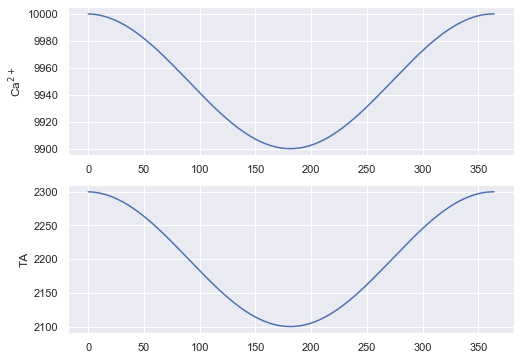

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1) # row-col-num
ax1 = fig.add_subplot(2, 1, 2)
ax.plot(ox, Ca_year); ax1.plot(ox, TA_year)
ax.set_ylabel('Ca$^{2+}$'); ax1.set_ylabel('TA');

**Figure M1-2**. TA response to $\text{Ca}^{2 +}$ change.

We see that consuming of 100 $\text{mM m}^{- 3}$ of $\text{Ca}^{2 +}$ decreases alkalinity by 200 $\text{mM m}^{- 3}$, which is obviously clear from $\text{TA}_{\text{ec}}$ expression.
Also it is clear that the local activities of calcifiers cannot increase alkalinity above 2300 $\text{mM m}^{- 3}$.
To increase TA we need an input of $\text{Ca}^{2 +}$, which can come in form of $\text{Ca}^{2 +}$ or $\text{CaCO}_3$.
Additional $\text{Ca}^{2 +}$ can come with terrestial input which we do not consider here.
The supply of allochthonuous $\text{CaCO}_3$ to the Wadden Sea has not yet been reported ([Thomas et al., 2009]).
Therefore according to the goal to calculate the maximum alkalinity generation in the Wadden Sea due to biogeochemical processes as a first approximation we can skip $\text{CaCO}_3$ precipitation / dissolution while preparing the biogeochemical model.

[Thomas et al., 2009]: https://doi.org/10.5194/bg-6-267-2009

Now let's assume that sulfate reduction decreases $\text{SO}_{4}^{2 -}$ by 100 $\text{mM m}^{- 3}$.

In [9]:
dSO4 = -sinusoidal(100); SO4_year = SO4 + dSO4
TA_year = alk_change(TA = 2300, dSO4 = dSO4)

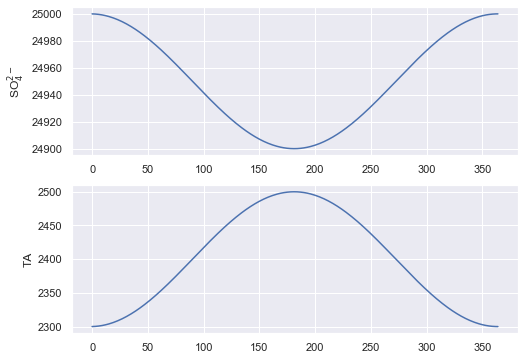

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(2, 1, 1);
ax1 = fig.add_subplot(2, 1, 2)
ax.plot(ox, SO4_year); ax1.plot(ox, TA_year)
ax.set_ylabel('SO$_4^{2-}$'); ax1.set_ylabel('TA');

**Figure M1-3**. TA response to $\text{SO}_{4}^{2 -}$ change.

The main difference from $\text{Ca}^{2 +}$ is that $\text{SO}_{4}^{2 -}$ is negatively charged.
So decrease of $\text{SO}_{4}^{2 -}$ by 100 $\text{mM m}^{- 3}$ increases TA by 200 $\text{mM m}^{- 3}$.
Also, since $\text{SO}_{4}^{2 -}$ is a mayor ion and very abundant in seawater sulfate reduction has a tremendous potential to increase alkalinity.
Therefore, sulfate reduction can be the most important reaction while considering alkalinity generation due to biogeochemical processes in the coastal area.

We have another quite abundant negatively charged conservative ion in the coastal area - $\text{NO}_{3}^{-}$.
But according to $\text{TA}_{\text{ec}}$ expression it changes TA only by one mole per mole of $\text{NO}_{3}^{-}$ consumed / excreted.
Also, the concentration of $\text{NO}_{3}^{-}$ even being high is far lower comparing to $\text{SO}_{4}^{2 -}$ ion.
Anyway, we cannot ignore $\text{NO}_{3}^{-}$ mainly because it precedes $\text{SO}_{4}^{2 -}$ in a sequence of relative energetics of microbially mediated redox reactions (Stumm, W. S., and J. J. Morgan (1981). Aquatic Chemistry, John Wiley & Sons, Inc., p. 460).

$\text{MnO}_2$ and $\text{FeOOH}$ electron acceptors are also energetically preferable to $\text{SO}_{4}^{2 -}$ for OM oxidation.
But in the biogeochemical model, we can omit $\text{MnO}_2$ and $\text{FeOOH}$ electron acceptors.
With these processes, there will be less OM available for sulfate reduction, but since there is no $\text{Fe}^{2+}$ and $\text{Mn}^{2+}$ in $\text{TA}_{\text{ec}}$ expression iron and manganese reduction produces less alkalinity then sulfate reduction.
Also, $\text{MnO}_2$ and $\text{FeOOH}$ can oxidize reduced sulfur compounds to sulfate, it will decrease TA according to $\text{TA}_{\text{ec}}$ expression.
We can omit these variables since this assumption does not underestimate TA generation what is in the scope of our goals.
Also, the contents of both $\text{FeOOH}$ and $\text{MnO}_2$ in the sediments of the Wadden Sea are quite low ([de Beer et al., 2005]).


[de Beer et al., 2005]: https://doi.org/10.4319/lo.2005.50.1.0113

According to the above reasoning and to the goal of the study (to estimate the maximum value of TA that can be generated in the Wadden Sea) we should include sulfate reduction and denitrification reactions into the biogeochemical model, but we can skip $\text{CaCO}_3$ precipitation/dissolution.
Also as the most energetically preferable, we cannot skip oxygen respiration.
Since the alkalinity generating reactions consume OM we should implement the opposite processes generating OM.
We have already taken into account the allochthonous OM coming from an external pool, we also need to add OM production into consideration.
Moreover, we shall add the reactions from nitrogen and sulfur cycles: nitrification reactions and sulfides oxidation reactions.
We provide a thorough description of them in the Methods 2 section.